<a href="https://colab.research.google.com/github/citizenyves/SemanticTextualSimilarity-KoELECTRA/blob/main/google_colab_ipynb/%E1%84%80%E1%85%B5%E1%84%8B%E1%85%A5%E1%86%B8%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A63_1%E1%84%90%E1%85%B5%E1%86%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REST API 서버코드 주소
https://github.com/citizenyves/SemanticTextualSimilarity-KoELECTRA/tree/main/API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# pip

In [ ]:
!pip install fastprogress

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 7.8 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 6.5 MB 84.6 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 895 kB 79.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Preset

In [ ]:
import os
import copy
import json
import logging
import re
from tqdm import tqdm

# Data
import pandas as pd
import tarfile
import json
import numpy as np
import random
import torch
import transformers
from numpy.lib.function_base import average
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter
# Visualize Loss 
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
from scipy.stats import pearsonr, spearmanr
from sklearn import metrics as sklearn_metrics

# Modeling
from transformers import (
    ElectraConfig,
    ElectraTokenizer,
    ElectraForSequenceClassification
)
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup
)

# Train
from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


In [ ]:
## Version.
print("[VERSION]")
print(f"torch: {torch.__version__}")
print(f"transformers: {transformers.__version__}")

[VERSION]
torch: 1.10.0+cu111
transformers: 4.17.0


In [ ]:
# # seed
# seed = 7777
# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# Modules

## Args

In [ ]:
args = {
  "task": "korsts",
  "evaluate_test_during_training": False,
  "do_lower_case": False,
  "do_train": True,
  "max_seq_len": 128,
  "num_train_epochs": 20,
  "weight_decay": 0.0,   # default = 1e-2
  "gradient_accumulation_steps": 1,
  "betas": (0.9, 0.999), # default
  "adam_epsilon": 1e-8,  # default
  "warmup_proportion": 0.2,
  "max_steps": -1,
  "max_grad_norm": 1.0,
  "no_cuda": False,
  "model_type": "koelectra-base-v3",
  "model_name_or_path": "monologg/koelectra-base-v3-discriminator",
  "seed": 42,
  "train_batch_size": 32,
  "eval_batch_size": 64,
  "learning_rate": 5e-5,
  "output_mode":"regression"
}


## Data

In [ ]:
def make_seed_dataset(df, col1, col2, f_label, b_label):
    # sentence pairs
    sent_pairs = [(sent1, sent2) for sent1, sent2 in zip(df[col1], df[col2])]
    
    # labels(float)
    labels = [label for label in df[f_label]]

    # labels(binary)
    b_labels = [label for label in df[b_label]]
    
    return sent_pairs, labels, b_labels


def batch_encode(tokenizer, sent_pairs):
    batch_encoding = tokenizer.batch_encode_plus(
                              [(pairs[0], pairs[1]) for pairs in tqdm(sent_pairs, total=len(sent_pairs))],
                              max_length=128,
                              padding="max_length",    
                              add_special_tokens=True,
                              truncation=True,
                              )
    return batch_encoding


def make_features(sent_pairs, batch_encoding, labels):
    features = []
    for i in tqdm(range(len(sent_pairs)), total=len(sent_pairs)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}
        if "token_type_ids" not in inputs:
            inputs["token_type_ids"] = [0] * len(inputs["input_ids"])

        feature = {'input_ids':inputs['input_ids'],
                  'attention_mask':inputs['attention_mask'],
                  'token_type_ids':inputs['token_type_ids'],
                  'label':labels[i]
                  }
        
        features.append(feature)
    
    return features


def make_inputs(features, output_mode:str="regression"):
    assert output_mode in ["classification", "regression"]

    # inputs
    all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)

    # label
    if output_mode == "classification":
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.float)
    else:
        raise AssertionError(output_mode)

    # dataset
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    return dataset


def make_dataloader(dataset, mode:str):
    assert mode in ['train', 'valid', 'dev']

    if mode == "train":
        dataloader = DataLoader(dataset = dataset, # (input_ids, attention_mask, token_type_ids, labels)
                                sampler = RandomSampler(dataset), 
                                batch_size = args['train_batch_size'])
    elif mode == "valid":
        dataloader = DataLoader(dataset = dataset, 
                                sampler = RandomSampler(dataset), 
                                batch_size = args['eval_batch_size'])
    elif mode == "dev":
        dataloader = DataLoader(dataset = dataset, 
                                sampler = SequentialSampler(dataset), 
                                batch_size = args['eval_batch_size'])
    else:
        raise AssertionError(mode)

    return dataloader

## Utils

In [ ]:
def init_logger():
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )

def set_seed(args):
    random.seed(args['seed'])
    np.random.seed(args['seed'])
    torch.manual_seed(args['seed'])
    if not args['no_cuda'] and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args['seed'])


def pearson_and_spearman(labels, preds):
    pearson_corr = pearsonr(preds, labels)[0]
    spearman_corr = spearmanr(preds, labels)[0]
    return {
        "pearson": pearson_corr,
        "spearmanr": spearman_corr,
        "corr": (pearson_corr + spearman_corr) / 2,
    }


def f1_pre_rec(labels, preds):
    return {
        "precision": sklearn_metrics.precision_score(labels, preds, average="macro"),
        "recall": sklearn_metrics.recall_score(labels, preds, average="macro"),
        "f1": sklearn_metrics.f1_score(labels, preds, average="macro"),
    }


def compute_metrics(metric_name, labels, preds):
    assert len(preds) == len(labels)
    if metric_name == "pearson_and_spearman":
        return pearson_and_spearman(labels, preds)
    elif metric_name == "f1_pre_rec":
        return f1_pre_rec(labels, preds)
    else:
        raise KeyError(metric_name)

## Processor

In [ ]:
class STSProcessor(object):
    """Processor for the KorSTS data set """

    def __init__(self, args):
        self.args = args

    def get_labels(self): # (need)
        return [None]

In [ ]:
seq_cls_processors = {
    "korsts": STSProcessor
}

seq_cls_tasks_num_labels = {
    "korsts": 1
}

seq_cls_output_modes = {
    "korsts": "regression"
}

CONFIG_CLASSES = {
    "koelectra-base-v3": ElectraConfig
}

TOKENIZER_CLASSES = {
    "koelectra-base-v3": ElectraTokenizer
}

MODEL_FOR_SEQUENCE_CLASSIFICATION = {
    "koelectra-base-v3": ElectraForSequenceClassification
}

## Run

In [ ]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss):
    file_name = f'{path}/model.ckpt.{epoch}'
    torch.save(
        {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'loss' : loss
        },
        file_name
    )

    print(f"Saving epoch {epoch} checkpoint at {file_name}")


class Initializer():
    def __init__(self, args):
        self.args = args
        self.config = CONFIG_CLASSES[args['model_type']].from_pretrained(
                args['model_name_or_path'],
                num_labels=seq_cls_tasks_num_labels[args['task']]
            )
        self.model = MODEL_FOR_SEQUENCE_CLASSIFICATION[args['model_type']].from_pretrained(
            args['model_name_or_path'],
            config=self.config
        )

    def model_initializer(self):
        """
        모델을 초기화한 후 반환
        """

        return self.model


    def opt_sch_initializer(self, model, train_dataloader):
        """
        옵티마이저, 스케쥴러를 초기화한 후 반환
        """

        # optimizer
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': self.args['weight_decay']}, #weight_decay = 0.0
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
            'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.args['learning_rate'],
                          eps=self.args['adam_epsilon'])
        
        # scheduler
        if self.args['max_steps'] > 0: 
            t_total = self.args['max_steps']
            self.args['num_train_epochs'] = self.args['max_steps'] // (len(train_dataloader) // self.args['gradient_accumulation_steps']) + 1
        else:
            t_total = len(train_dataloader) // self.args['gradient_accumulation_steps'] * self.args['num_train_epochs']

        scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                                    num_warmup_steps=int(t_total * self.args['warmup_proportion']), #0 
                                                    num_training_steps=t_total)
        
        return optimizer, scheduler, t_total

# Load Data

In [ ]:
# train, dev json 로드
train_json = "klue-sts-v1.1_train.json"
dev_json = "klue-sts-v1.1_dev.json"

with open(f"/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/data/{train_json}", "r") as train_json:
    train = json.load(train_json)

with open(f"/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/data/{dev_json}", "r") as dev_json:
    dev = json.load(dev_json)


# json to csv
train = pd.json_normalize(train).iloc[:, 0:7]
dev = pd.json_normalize(dev).iloc[:, 0:7]

In [ ]:
# # CSV파일로 저장하기
# train.to_csv("/content/drive/MyDrive/preon_nlp/train.csv", index = False)
# dev.to_csv("/content/drive/MyDrive/preon_nlp/dev.csv", index = False)

# # CSV파일 읽기
# t_path = "/content/drive/MyDrive/preon_nlp/train.csv"
# d_path = "/content/drive/MyDrive/preon_nlp/dev.csv"
# train = pd.read_csv(t_path)
# dev = pd.read_csv(d_path)

In [ ]:
print(f"train set shape : {train.shape}")
print(f"dev set shape   : {dev.shape}")

train set shape : (11668, 7)
dev set shape   : (519, 7)


In [ ]:
train.head(3)

,guid,source,sentence1,sentence2,labels.label,labels.real-label,labels.binary-label
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.7,3.714286,1
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,0.0,0.000000,0
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.3,0.333333,0


In [ ]:
dev.head(3)

,guid,source,sentence1,sentence2,labels.label,labels.real-label,labels.binary-label
0,klue-sts-v1_dev_00000,airbnb-rtt,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.9,4.857143,1
1,klue-sts-v1_dev_00001,airbnb-sampled,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.4,1.428571,0
2,klue-sts-v1_dev_00002,policy-sampled,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.3,1.285714,0


# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11668 entries, 0 to 11667
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   guid                 11668 non-null  object 
 1   source               11668 non-null  object 
 2   sentence1            11668 non-null  object 
 3   sentence2            11668 non-null  object 
 4   labels.label         11668 non-null  float64
 5   labels.real-label    11668 non-null  float64
 6   labels.binary-label  11668 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 638.2+ KB


In [ ]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   guid                 519 non-null    object 
 1   source               519 non-null    object 
 2   sentence1            519 non-null    object 
 3   sentence2            519 non-null    object 
 4   labels.label         519 non-null    float64
 5   labels.real-label    519 non-null    float64
 6   labels.binary-label  519 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 28.5+ KB


In [ ]:
# 결측값 확인
print(f"{train.isnull().sum()}\n")
print(dev.isnull().sum())

guid                   0
source                 0
sentence1              0
sentence2              0
labels.label           0
labels.real-label      0
labels.binary-label    0
dtype: int64

guid                   0
source                 0
sentence1              0
sentence2              0
labels.label           0
labels.real-label      0
labels.binary-label    0
dtype: int64


In [ ]:
# 중복값 확인
train.duplicated(subset=['source','sentence1','sentence2','labels.label','labels.real-label','labels.binary-label']).sum()

5

In [ ]:
# 중복값 확인
dev.duplicated(subset=['source','sentence1','sentence2','labels.label','labels.real-label','labels.binary-label']).sum()

0

In [ ]:
# 중복값 제거
train.drop_duplicates(subset=['source','sentence1','sentence2','labels.label','labels.real-label','labels.binary-label'], inplace=True)

In [ ]:
# shape 확인
train.shape

(11663, 7)

In [ ]:
# 컬럼명 변경
train.columns = ['guid', 'src', 'sent1', 'sent2', 'f_label', 'real_f_label', 'b_label']
dev.columns = ['guid', 'src', 'sent1', 'sent2', 'f_label', 'real_f_label', 'b_label']

In [ ]:
train.head()

,guid,src,sent1,sent2,f_label,real_f_label,b_label
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.7,3.714286,1
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,0.0,0.000000,0
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.3,0.333333,0
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.",0.6,0.571429,0
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,4.7,4.714286,1


In [ ]:
# 문장당 토큰수에 대한 통계치 확인
tokenizer = ElectraTokenizer.from_pretrained(args['model_name_or_path'], do_lower_case=False)

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

In [ ]:
def describe_sentence_statistic(dataset, tokenizer):
    len_sent1 = []
    len_sent2 = []

    for sent1, sent2 in tqdm(zip(dataset['sent1'], dataset['sent2']), total=len(dataset)):
        len_sent1.append(len(tokenizer.encode(sent1)))
        len_sent2.append(len(tokenizer.encode(sent2)))

    describe = pd.DataFrame(data={'sent 1':len_sent1, 'sent 2':len_sent2})\
                 .describe(percentiles=[.05, .10, .25, .5, .75, .90, .95, .99, .999, .9999,.99999])
    
    return describe

In [ ]:
train_describe = describe_sentence_statistic(train, tokenizer)
dev_describe = describe_sentence_statistic(dev, tokenizer)

100%|██████████| 519/519 [00:00<00:00, 1988.99it/s]


In [ ]:
train_describe

,sent 1,sent 2
count,11663.000000,11663.000000
mean,20.294778,19.803824
std,8.913938,8.392465
min,5.000000,5.000000
5%,11.000000,11.000000
10%,13.000000,12.000000
25%,15.000000,14.000000
50%,18.000000,17.000000
75%,23.000000,22.000000
90%,33.000000,32.000000


In [ ]:
dev_describe

,sent 1,sent 2
count,519.000000,519.000000
mean,19.753372,19.672447
std,8.453419,8.305498
min,6.000000,7.000000
5%,11.900000,11.000000
10%,12.800000,13.000000
25%,15.000000,15.000000
50%,17.000000,17.000000
75%,22.000000,22.000000
90%,31.000000,31.000000


In [ ]:
# train, val 분할
train, val = train_test_split(train, test_size=0.1, random_state=args['seed'])

In [ ]:
# train, val 데이터수 확인
print(f"훈련데이터 개수 : {len(train)}")
print(f"검증데이터 개수 : {len(val)}")

훈련데이터 개수 : 10496
검증데이터 개수 : 1167


# Make Inputs

## seed

In [ ]:
"""
sent_paris : (문장1, 문장2) pair
labels     : (float) label
b_label    : (binary) label
"""

# train dataset
t_sent_pairs, t_labels, t_b_labels = make_seed_dataset(train, 'sent1', 'sent2', 'real_f_label', 'b_label')

# validation dataset
v_sent_pairs, v_labels, v_b_labels = make_seed_dataset(val, 'sent1', 'sent2', 'real_f_label', 'b_label')

# dev dataset
d_sent_pairs, d_labels, d_b_labels = make_seed_dataset(dev, 'sent1', 'sent2', 'real_f_label', 'b_label')

In [ ]:
# 데이터 개수 확인
print("\t   train\tvalid\t\tdev\n")
print(f"paris    : {len(t_sent_pairs)}\t{len(v_sent_pairs)}\t\t{len(d_sent_pairs)}")
print(f"labels   : {len(t_labels)}\t{len(v_labels)}\t\t{len(d_labels)}")
print(f"b_labels : {len(t_b_labels)}\t{len(v_b_labels)}\t\t{len(d_b_labels)}")

	   train	valid		dev

paris    : 10496	1167		519
labels   : 10496	1167		519
b_labels : 10496	1167		519


In [ ]:
# 샘플 확인
print(f"pairs    : {t_sent_pairs[2]}")
print(f"labels   : {t_labels[2]}")
print(f"b_labels : {t_b_labels[2]}")

pairs    : ('이를 위해 3가지 협력 방향을 제안합니다.', '이를 위해, 우리는 세 가지 협력적인 방향을 제안합니다.')
labels   : 4.166666666666667
b_labels : 1


## encoding

In [ ]:
del tokenizer

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained(args['model_name_or_path'], do_lower_case=False)

In [ ]:
# Do encode
t_batch_encoding = batch_encode(tokenizer, t_sent_pairs)
v_batch_encoding = batch_encode(tokenizer, v_sent_pairs) 
d_batch_encoding = batch_encode(tokenizer, d_sent_pairs)

100%|██████████| 519/519 [00:00<00:00, 1186937.72it/s]


In [ ]:
print(f"input_ids      : {t_batch_encoding['input_ids'][0]}")
print(f"attention_mask : {t_batch_encoding['attention_mask'][0]}")
print(f"token_type_ids : {t_batch_encoding['token_type_ids'][0]}")

input_ids      : [2, 8258, 6769, 4073, 4129, 6654, 4129, 7862, 6429, 3496, 4031, 4239, 8049, 26093, 35, 3, 8027, 4112, 23502, 4137, 3305, 6231, 4176, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Inputs 수 확인
print("\t\t   train\tvalid\t\tdev\n")
print(f"input_ids        : {len(t_batch_encoding['input_ids'])}\t{len(v_batch_encoding['input_ids'])}\t\t{len(d_batch_encoding['input_ids'])}")
print(f"attention_mask   : {len(t_batch_encoding['attention_mask'])}\t{len(v_batch_encoding['attention_mask'])}\t\t{len(d_batch_encoding['attention_mask'])}")
print(f"token_type_ids   : {len(t_batch_encoding['token_type_ids'])}\t{len(v_batch_encoding['token_type_ids'])}\t\t{len(d_batch_encoding['token_type_ids'])}")

		   train	valid		dev

input_ids        : 10496	1167		519
attention_mask   : 10496	1167		519
token_type_ids   : 10496	1167		519


## features

In [ ]:
# Get features 
t_features = make_features(t_sent_pairs, t_batch_encoding, t_labels)
v_features = make_features(v_sent_pairs, v_batch_encoding, v_labels)
d_features = make_features(d_sent_pairs, d_batch_encoding, d_labels)

100%|██████████| 519/519 [00:00<00:00, 257736.65it/s]


In [ ]:
# features keys 확인
t_features[0].keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'label'])

## inputs

In [ ]:
# make inputs
%%time
t_dataset = make_inputs(t_features)
v_dataset = make_inputs(v_features)
d_dataset = make_inputs(d_features)

CPU times: user 85.4 ms, sys: 12.2 ms, total: 97.6 ms
Wall time: 122 ms


In [ ]:
# inputs 개수 확인
len(t_dataset), len(v_dataset), len(d_dataset)

(10496, 1167, 519)

In [ ]:
t_dataset[2]

(tensor([    2,  3240,  4110,  6237,    23,  6981,  6840,  7005,  4292,  7200,
         17788,    18,     3,  3240,  4110,  6237,    16,  6233,  4034,  2926,
          6274,  6840,  4199,  4139,  7005,  4292,  7200, 17788,    18,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

## DataLoader

In [ ]:
train_dataloader = make_dataloader(t_dataset, mode='train')
valid_dataloader = make_dataloader(v_dataset, mode='valid')
dev_dataloader = make_dataloader(d_dataset, mode='dev')

In [ ]:
for idx, input in enumerate(train_dataloader):
    if idx < 1:
        print(input)
    else:
        break

[tensor([[    2,  6285,  3181,  ...,     0,     0,     0],
        [    2,  6451,  9736,  ...,     0,     0,     0],
        [    2, 12860,  4073,  ...,     0,     0,     0],
        ...,
        [    2,  6890, 16521,  ...,     0,     0,     0],
        [    2,  2556, 10781,  ...,     0,     0,     0],
        [    2,    22,  4370,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([4.5000, 0.0000, 0.2000, 0.8333, 4.1667, 0.4286, 2.5000, 0.7143, 3.8571,
        1.1429, 0.7143, 4.6667, 0.6667, 3.6000, 4.2857, 0.0000, 4.4000, 0.0000,
        0.0000, 0.0000, 0.0000, 4.2857

# Train(Validate) / Save models

In [ ]:
# log 파일을 저장할 경로를 지정
logdir_path = "/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/logdir"
writer = SummaryWriter(logdir_path)

In [ ]:
# '__main__' 이름의 logger 생성
logger = logging.getLogger(__name__)

In [ ]:
def train(args, model, train_dataloader, valid_dataloader=None):
    # 1 epoch 주기로 train, val loss를 저장하는 리스트
    avg_tr_loss_li = []
    avg_val_loss_li = []

    # train total steps
    if args['max_steps'] > 0: 
        t_total = args['max_steps']
        args['num_train_epochs'] = args['max_steps'] // (len(train_dataloader) // args['gradient_accumulation_steps']) + 1
    else:
        t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']

    # optimizer and scheduler
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters,
                      lr=args['learning_rate'],
                      betas=args['betas'],
                      eps=args['adam_epsilon'])
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                                num_warmup_steps=int(t_total * args['warmup_proportion']), 
                                                num_training_steps=t_total)

    # Load optimizer and scheduler states
    if os.path.isfile(os.path.join(args['model_name_or_path'], "optimizer.pt")) and os.path.isfile(
            os.path.join(args['model_name_or_path'], "scheduler.pt")
    ):
        optimizer.load_state_dict(torch.load(os.path.join(args['model_name_or_path'], "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args['model_name_or_path'], "scheduler.pt")))

    # logger info
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(t_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    # step and loss 초기화
    global_step, batch_step = 0, 0
    tr_loss, batch_loss = 0.0, 0.0

    # zero_grad
    model.zero_grad()

    # Train!
    mb = master_bar(range(int(args['num_train_epochs'])))
    for epoch in tqdm(mb):
        epoch_iterator = progress_bar(train_dataloader, parent=mb)
        for step, batch in enumerate(epoch_iterator):
            batch_step+=1
            
            # train mode
            model.train()
            
            # inputs to device
            batch = tuple(item.to(device) for item in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # forward
            outputs = model(**inputs)

            # loss 
            loss = outputs[0]
            # loss depending on the gradient_accumulation_steps
            if args['gradient_accumulation_steps'] > 1: 
                loss = loss / args['gradient_accumulation_steps']

            # backward
            loss.backward()

            # batch_loss & (total)loss
            batch_loss += loss.item()
            tr_loss += loss.item()
            
            if (step + 1) % args['gradient_accumulation_steps'] == 0 or (
                    len(train_dataloader) <= args['gradient_accumulation_steps']
                    and (step + 1) == len(train_dataloader)
            ):  # gradient clipping (max_norm = 1)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                               max_norm = args['max_grad_norm'])
                
                # optimizer & scheduler 업데이트
                optimizer.step()
                scheduler.step()

                # batch마다 모델이 갖고 있는 기존 gradient를 초기화
                model.zero_grad()
                
                # tensorboard : Train loss 기록
                writer.add_scalar(
                        tag = "Train loss",
                        scalar_value = batch_loss / batch_step,
                        global_step = epoch * len(train_dataloader)
                )

                # tensorboard : learning rate 기록
                writer.add_scalar(
                        tag = "Train LR",
                        scalar_value = optimizer.param_groups[0]['lr'],
                        global_step = epoch * len(train_dataloader)
                ) 
                
                # 배치 10개씩 처리할 때마다 lr, 평균 train loss를 출력
                if (step % 10 == 0 and step != 0):
                    learning_rate = optimizer.param_groups[0]['lr']
                    print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_step:.4f}")
                    
                    # batch_loss, batch_step 초기화
                    batch_loss, batch_step = 0.0, 0

                global_step += 1
        
            if args['max_steps'] > 0 and global_step > args['max_steps']:
                break

        # 1 epoch 마다 평균 train loss 계산 및 출력
        avg_tr_loss = round(tr_loss / global_step, 4)
        avg_tr_loss_li.append(avg_tr_loss)
        print(f"Epoch {epoch} Train Loss : {avg_tr_loss}")

        # Validate!
        if valid_dataloader is not None:
            print(f"*****Epoch {epoch} Valid Start*****")
            results, val_loss = validate(args, model, valid_dataloader, "valid", global_step)
            avg_val_loss_li.append(val_loss)
            print(f"Epoch {epoch} Valid Loss : {val_loss:.4f}")
            print(f"*****Epoch {epoch} Train and Valid Finish*****\n")
            
            # tensorboard : Validation loss 기록 
            writer.add_scalar(
                tag = "Valid Loss",
                scalar_value = val_loss,
                global_step = epoch * len(valid_dataloader)
            )
        
        # 1 epoch 주기로 checkpoint 저장
        path = "/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model"
        save_checkpoint(path, model, optimizer, scheduler, epoch, loss)

        mb.write("Epoch {} done".format(epoch))

        if args['max_steps'] > 0 and global_step > args['max_steps']:
            break
    
    print("Train Completed. End Program.")
    # tensorboard 기록 중지
    writer.close()  

    return global_step, tr_loss / global_step, avg_tr_loss_li, avg_val_loss_li

In [ ]:
def validate(args, model, valid_dataloader, mode, global_step=None):
    results = {}

    # logger info
    if global_step != None:
        logger.info("***** Running evaluation on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running evaluation on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(v_dataset)))
    logger.info("  Eval Batch size = {}".format(args['eval_batch_size']))
		
    # loss, steps, 예측값, 라벨 초기화    
    loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label = None
    
    # validate !
    for batch in progress_bar(valid_dataloader):
        # eval mode
        model.eval()

        # inputs to device
        batch = tuple(item.to(device) for item in batch)

        # no_grad
        with torch.no_grad():
            # inputs
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # outputs
            outputs = model(**inputs)

            # loss and logits
            tmp_eval_loss, logits = outputs[:2]
            loss += tmp_eval_loss.mean().item()

        nb_eval_steps += 1
        
        # Get preds and out_label(예측값 & 라벨)
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label = np.append(out_label, inputs["labels"].detach().cpu().numpy(), axis=0)

    # 1 epoch 당 평균 validation loss 
    loss = loss / nb_eval_steps
    
    # preds depending on the type of task
    if seq_cls_output_modes[args['task']] == "classification":
        preds = np.argmax(preds, axis=1)
    elif seq_cls_output_modes[args['task']] == "regression":
        preds = np.squeeze(preds)

    # Pearson correlation coefficient and Spearman correlation coefficient
    result = compute_metrics("pearson_and_spearman", out_label, preds)
    results.update(result)

    return results, loss

In [ ]:
def main(args):

    init_logger()
    set_seed(args)
    
    # STSProcessor
    processor = seq_cls_processors[args['task']](args)
    labels = processor.get_labels()
    
    # regression 방식으로 train 
    if seq_cls_output_modes[args['task']] == "regression":
        config = CONFIG_CLASSES[args['model_type']].from_pretrained(
            args['model_name_or_path'],
            num_labels=seq_cls_tasks_num_labels[args['task']]
        )
    else:
        raise KeyError("The task is not 'regression' !")
    
    # 모델 (koelectra-base-v3-discriminator)
    model = MODEL_FOR_SEQUENCE_CLASSIFICATION[args['model_type']].from_pretrained(
        args['model_name_or_path'],
        config=config
    )

    # GPU or CPU
    args['device'] = "cuda" if torch.cuda.is_available() and not args['no_cuda'] else "cpu"
    model.to(args['device'])
    
    # Train !
    if args['do_train']:
        global_step, tr_loss, avg_tr_loss_li, avg_val_loss_li = train(args, model, train_dataloader, valid_dataloader)
        logger.info(" global_step = {}, average loss = {}".format(global_step, tr_loss))
    else:
        raise AssertionError(args['do_train'])

    return  global_step, tr_loss, avg_tr_loss_li, avg_val_loss_li

In [ ]:
# 훈련 / 검증
global_step, tr_loss, avg_tr_loss_li, avg_val_loss_li = main(args)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Epoch: 0, Step : 10, LR : 4.192073170731708e-07, Avg Loss : 8.3839
Epoch: 0, Step : 20, LR : 8.003048780487805e-07, Avg Loss : 9.0488
Epoch: 0, Step : 30, LR : 1.1814024390243904e-06, Avg Loss : 9.1918
Epoch: 0, Step : 40, LR : 1.5625e-06, Avg Loss : 8.2329
Epoch: 0, Step : 50, LR : 1.94359756097561e-06, Avg Loss : 7.9872
Epoch: 0, Step : 60, LR : 2.3246951219512196e-06, Avg Loss : 6.3265
Epoch: 0, Step : 70, LR : 2.7057926829268293e-06, Avg Loss : 6.8421
Epoch: 0, Step : 80, LR : 3.086890243902439e-06, Avg Loss : 6.8252
Epoch: 0, Step : 90, LR : 3.467987804878049e-06, Avg Loss : 6.3420
Epoch: 0, Step : 100, LR : 3.849085365853659e-06, Avg Loss : 5.8245
Epoch: 0, Step : 110, LR : 4.230182926829269e-06, Avg Loss : 4.9849
Epoch: 0, Step : 120, LR : 4.611280487804878e-06, Avg Loss : 5.1857
Epoch: 0, Step : 130, LR : 4.992378048780488e-06, Avg Loss : 4.2684
Epoch: 0, Step : 140, LR : 5.373475609756097e-06, Avg Loss : 4.1337
Epoch: 0, Step : 150, LR : 5.7545731707317075e-06, Avg Loss : 3.63

03/29/2022 08:43:51 - INFO - __main__ -   ***** Running evaluation on valid dataset (328 step) *****
03/29/2022 08:43:51 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:43:51 - INFO - __main__ -     Eval Batch size = 64


Epoch 0 Train Loss : 3.5253
*****Epoch 0 Valid Start*****


Epoch 0 Valid Loss : 0.3274
*****Epoch 0 Train and Valid Finish*****



1it [02:17, 137.70s/it]

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.0
Epoch: 1, Step : 10, LR : 1.2919207317073171e-05, Avg Loss : 0.2787
Epoch: 1, Step : 20, LR : 1.3300304878048781e-05, Avg Loss : 0.2779
Epoch: 1, Step : 30, LR : 1.3681402439024391e-05, Avg Loss : 0.2548
Epoch: 1, Step : 40, LR : 1.4062500000000001e-05, Avg Loss : 0.2292
Epoch: 1, Step : 50, LR : 1.4443597560975611e-05, Avg Loss : 0.1726
Epoch: 1, Step : 60, LR : 1.4824695121951221e-05, Avg Loss : 0.1580
Epoch: 1, Step : 70, LR : 1.5205792682926832e-05, Avg Loss : 0.2214
Epoch: 1, Step : 80, LR : 1.558689024390244e-05, Avg Loss : 0.2292
Epoch: 1, Step : 90, LR : 1.596798780487805e-05, Avg Loss : 0.1924
Epoch: 1, Step : 100, LR : 1.634908536585366e-05, Avg Loss : 0.1979
Epoch: 1, Step : 110, LR : 1.673018292682927e-05, Avg Loss : 0.2058
Epoch: 1, Step : 120, LR : 1.711128048780488e-05, Avg Loss : 0.2287
Epoch: 1, Step : 130, LR : 1.749237804878049e-05, Avg Loss : 0

03/29/2022 08:46:09 - INFO - __main__ -   ***** Running evaluation on valid dataset (656 step) *****
03/29/2022 08:46:09 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:46:09 - INFO - __main__ -     Eval Batch size = 64


Epoch 1 Train Loss : 1.8615
*****Epoch 1 Valid Start*****


Epoch 1 Valid Loss : 0.3242
*****Epoch 1 Train and Valid Finish*****



2it [04:34, 136.89s/it]

Saving epoch 1 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.1
Epoch: 2, Step : 10, LR : 2.5419207317073175e-05, Avg Loss : 0.1380
Epoch: 2, Step : 20, LR : 2.5800304878048782e-05, Avg Loss : 0.1172
Epoch: 2, Step : 30, LR : 2.6181402439024395e-05, Avg Loss : 0.1376
Epoch: 2, Step : 40, LR : 2.6562500000000002e-05, Avg Loss : 0.1834
Epoch: 2, Step : 50, LR : 2.694359756097561e-05, Avg Loss : 0.1204
Epoch: 2, Step : 60, LR : 2.7324695121951222e-05, Avg Loss : 0.1329
Epoch: 2, Step : 70, LR : 2.770579268292683e-05, Avg Loss : 0.1055
Epoch: 2, Step : 80, LR : 2.8086890243902442e-05, Avg Loss : 0.1351
Epoch: 2, Step : 90, LR : 2.846798780487805e-05, Avg Loss : 0.1345
Epoch: 2, Step : 100, LR : 2.8849085365853662e-05, Avg Loss : 0.1144
Epoch: 2, Step : 110, LR : 2.923018292682927e-05, Avg Loss : 0.3073
Epoch: 2, Step : 120, LR : 2.9611280487804883e-05, Avg Loss : 0.3317
Epoch: 2, Step : 130, LR : 2.999237804878049e-05, Avg Loss : 

03/29/2022 08:48:25 - INFO - __main__ -   ***** Running evaluation on valid dataset (984 step) *****
03/29/2022 08:48:25 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:48:25 - INFO - __main__ -     Eval Batch size = 64


Epoch 2 Train Loss : 1.2984
*****Epoch 2 Valid Start*****


Epoch 2 Valid Loss : 0.1465
*****Epoch 2 Train and Valid Finish*****



3it [06:50, 136.58s/it]

Saving epoch 2 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.2
Epoch: 3, Step : 10, LR : 3.791920731707318e-05, Avg Loss : 0.1627
Epoch: 3, Step : 20, LR : 3.830030487804878e-05, Avg Loss : 0.1694
Epoch: 3, Step : 30, LR : 3.86814024390244e-05, Avg Loss : 0.1350
Epoch: 3, Step : 40, LR : 3.90625e-05, Avg Loss : 0.1262
Epoch: 3, Step : 50, LR : 3.944359756097561e-05, Avg Loss : 0.1286
Epoch: 3, Step : 60, LR : 3.982469512195122e-05, Avg Loss : 0.1059
Epoch: 3, Step : 70, LR : 4.020579268292683e-05, Avg Loss : 0.1186
Epoch: 3, Step : 80, LR : 4.058689024390244e-05, Avg Loss : 0.1475
Epoch: 3, Step : 90, LR : 4.096798780487805e-05, Avg Loss : 0.1366
Epoch: 3, Step : 100, LR : 4.134908536585366e-05, Avg Loss : 0.1731
Epoch: 3, Step : 110, LR : 4.173018292682927e-05, Avg Loss : 0.1212
Epoch: 3, Step : 120, LR : 4.211128048780488e-05, Avg Loss : 0.1666
Epoch: 3, Step : 130, LR : 4.249237804878049e-05, Avg Loss : 0.1853
Epoch: 3, St

03/29/2022 08:50:42 - INFO - __main__ -   ***** Running evaluation on valid dataset (1312 step) *****
03/29/2022 08:50:42 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:50:42 - INFO - __main__ -     Eval Batch size = 64


Epoch 3 Train Loss : 1.0089
*****Epoch 3 Valid Start*****


Epoch 3 Valid Loss : 0.3338
*****Epoch 3 Train and Valid Finish*****



4it [09:06, 136.63s/it]

Saving epoch 3 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.3
Epoch: 4, Step : 10, LR : 4.989519817073171e-05, Avg Loss : 0.1485
Epoch: 4, Step : 20, LR : 4.97999237804878e-05, Avg Loss : 0.1232
Epoch: 4, Step : 30, LR : 4.970464939024391e-05, Avg Loss : 0.1017
Epoch: 4, Step : 40, LR : 4.9609375000000005e-05, Avg Loss : 0.0879
Epoch: 4, Step : 50, LR : 4.9514100609756095e-05, Avg Loss : 0.1102
Epoch: 4, Step : 60, LR : 4.94188262195122e-05, Avg Loss : 0.1369
Epoch: 4, Step : 70, LR : 4.93235518292683e-05, Avg Loss : 0.1074
Epoch: 4, Step : 80, LR : 4.9228277439024395e-05, Avg Loss : 0.1034
Epoch: 4, Step : 90, LR : 4.913300304878049e-05, Avg Loss : 0.1088
Epoch: 4, Step : 100, LR : 4.903772865853658e-05, Avg Loss : 0.0943
Epoch: 4, Step : 110, LR : 4.894245426829269e-05, Avg Loss : 0.1192
Epoch: 4, Step : 120, LR : 4.8847179878048785e-05, Avg Loss : 0.1019
Epoch: 4, Step : 130, LR : 4.875190548780488e-05, Avg Loss : 0.1109


03/29/2022 08:52:58 - INFO - __main__ -   ***** Running evaluation on valid dataset (1640 step) *****
03/29/2022 08:52:58 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:52:58 - INFO - __main__ -     Eval Batch size = 64


Epoch 4 Train Loss : 0.8287
*****Epoch 4 Valid Start*****


Epoch 4 Valid Loss : 0.1522
*****Epoch 4 Train and Valid Finish*****



5it [11:22, 136.41s/it]

Saving epoch 4 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.4
Epoch: 5, Step : 10, LR : 4.677019817073171e-05, Avg Loss : 0.0900
Epoch: 5, Step : 20, LR : 4.667492378048781e-05, Avg Loss : 0.0797
Epoch: 5, Step : 30, LR : 4.6579649390243906e-05, Avg Loss : 0.0845
Epoch: 5, Step : 40, LR : 4.6484375e-05, Avg Loss : 0.0813
Epoch: 5, Step : 50, LR : 4.63891006097561e-05, Avg Loss : 0.0858
Epoch: 5, Step : 60, LR : 4.62938262195122e-05, Avg Loss : 0.0745
Epoch: 5, Step : 70, LR : 4.6198551829268296e-05, Avg Loss : 0.0916
Epoch: 5, Step : 80, LR : 4.610327743902439e-05, Avg Loss : 0.0882
Epoch: 5, Step : 90, LR : 4.600800304878049e-05, Avg Loss : 0.0657
Epoch: 5, Step : 100, LR : 4.591272865853659e-05, Avg Loss : 0.1012
Epoch: 5, Step : 110, LR : 4.5817454268292686e-05, Avg Loss : 0.0776
Epoch: 5, Step : 120, LR : 4.572217987804878e-05, Avg Loss : 0.0839
Epoch: 5, Step : 130, LR : 4.562690548780488e-05, Avg Loss : 0.0736
Epoch: 5

03/29/2022 08:55:14 - INFO - __main__ -   ***** Running evaluation on valid dataset (1968 step) *****
03/29/2022 08:55:14 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:55:14 - INFO - __main__ -     Eval Batch size = 64


Epoch 5 Train Loss : 0.7044
*****Epoch 5 Valid Start*****


Epoch 5 Valid Loss : 0.1763
*****Epoch 5 Train and Valid Finish*****



6it [13:40, 136.69s/it]

Saving epoch 5 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.5
Epoch: 6, Step : 10, LR : 4.364519817073171e-05, Avg Loss : 0.0733
Epoch: 6, Step : 20, LR : 4.354992378048781e-05, Avg Loss : 0.0676
Epoch: 6, Step : 30, LR : 4.3454649390243904e-05, Avg Loss : 0.0666
Epoch: 6, Step : 40, LR : 4.3359375e-05, Avg Loss : 0.0660
Epoch: 6, Step : 50, LR : 4.32641006097561e-05, Avg Loss : 0.0595
Epoch: 6, Step : 60, LR : 4.31688262195122e-05, Avg Loss : 0.0667
Epoch: 6, Step : 70, LR : 4.3073551829268294e-05, Avg Loss : 0.0621
Epoch: 6, Step : 80, LR : 4.297827743902439e-05, Avg Loss : 0.0550
Epoch: 6, Step : 90, LR : 4.288300304878049e-05, Avg Loss : 0.0714
Epoch: 6, Step : 100, LR : 4.278772865853659e-05, Avg Loss : 0.0478
Epoch: 6, Step : 110, LR : 4.2692454268292684e-05, Avg Loss : 0.0673
Epoch: 6, Step : 120, LR : 4.259717987804878e-05, Avg Loss : 0.0658
Epoch: 6, Step : 130, LR : 4.2501905487804886e-05, Avg Loss : 0.0572
Epoch: 

03/29/2022 08:57:32 - INFO - __main__ -   ***** Running evaluation on valid dataset (2296 step) *****
03/29/2022 08:57:32 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:57:32 - INFO - __main__ -     Eval Batch size = 64


Epoch 6 Train Loss : 0.613
*****Epoch 6 Valid Start*****


Epoch 6 Valid Loss : 0.1612
*****Epoch 6 Train and Valid Finish*****



7it [15:56, 136.56s/it]

Saving epoch 6 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.6
Epoch: 7, Step : 10, LR : 4.052019817073171e-05, Avg Loss : 0.0488
Epoch: 7, Step : 20, LR : 4.0424923780487806e-05, Avg Loss : 0.0610
Epoch: 7, Step : 30, LR : 4.032964939024391e-05, Avg Loss : 0.0562
Epoch: 7, Step : 40, LR : 4.0234375e-05, Avg Loss : 0.0550
Epoch: 7, Step : 50, LR : 4.01391006097561e-05, Avg Loss : 0.0446
Epoch: 7, Step : 60, LR : 4.0043826219512195e-05, Avg Loss : 0.0437
Epoch: 7, Step : 70, LR : 3.994855182926829e-05, Avg Loss : 0.0477
Epoch: 7, Step : 80, LR : 3.98532774390244e-05, Avg Loss : 0.0622
Epoch: 7, Step : 90, LR : 3.975800304878049e-05, Avg Loss : 0.0655
Epoch: 7, Step : 100, LR : 3.9662728658536585e-05, Avg Loss : 0.0523
Epoch: 7, Step : 110, LR : 3.956745426829269e-05, Avg Loss : 0.0588
Epoch: 7, Step : 120, LR : 3.947217987804878e-05, Avg Loss : 0.0531
Epoch: 7, Step : 130, LR : 3.9376905487804885e-05, Avg Loss : 0.0568
Epoch: 

03/29/2022 08:59:48 - INFO - __main__ -   ***** Running evaluation on valid dataset (2624 step) *****
03/29/2022 08:59:48 - INFO - __main__ -     Num examples = 1167
03/29/2022 08:59:48 - INFO - __main__ -     Eval Batch size = 64


Epoch 7 Train Loss : 0.5429
*****Epoch 7 Valid Start*****


Epoch 7 Valid Loss : 0.1988
*****Epoch 7 Train and Valid Finish*****



8it [18:14, 137.11s/it]

Saving epoch 7 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.7
Epoch: 8, Step : 10, LR : 3.7395198170731713e-05, Avg Loss : 0.0483
Epoch: 8, Step : 20, LR : 3.7299923780487804e-05, Avg Loss : 0.0379
Epoch: 8, Step : 30, LR : 3.720464939024391e-05, Avg Loss : 0.0500
Epoch: 8, Step : 40, LR : 3.7109375e-05, Avg Loss : 0.0486
Epoch: 8, Step : 50, LR : 3.7014100609756097e-05, Avg Loss : 0.0421
Epoch: 8, Step : 60, LR : 3.69188262195122e-05, Avg Loss : 0.0412
Epoch: 8, Step : 70, LR : 3.682355182926829e-05, Avg Loss : 0.0333
Epoch: 8, Step : 80, LR : 3.6728277439024396e-05, Avg Loss : 0.0394
Epoch: 8, Step : 90, LR : 3.6633003048780486e-05, Avg Loss : 0.0482
Epoch: 8, Step : 100, LR : 3.6537728658536584e-05, Avg Loss : 0.0371
Epoch: 8, Step : 110, LR : 3.644245426829269e-05, Avg Loss : 0.0351
Epoch: 8, Step : 120, LR : 3.634717987804878e-05, Avg Loss : 0.0481
Epoch: 8, Step : 130, LR : 3.625190548780488e-05, Avg Loss : 0.0452
Epoc

03/29/2022 09:02:06 - INFO - __main__ -   ***** Running evaluation on valid dataset (2952 step) *****
03/29/2022 09:02:06 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:02:06 - INFO - __main__ -     Eval Batch size = 64


Epoch 8 Train Loss : 0.4873
*****Epoch 8 Valid Start*****


Epoch 8 Valid Loss : 0.1840
*****Epoch 8 Train and Valid Finish*****



9it [20:30, 136.78s/it]

Saving epoch 8 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.8
Epoch: 9, Step : 10, LR : 3.427019817073171e-05, Avg Loss : 0.0431
Epoch: 9, Step : 20, LR : 3.41749237804878e-05, Avg Loss : 0.0367
Epoch: 9, Step : 30, LR : 3.407964939024391e-05, Avg Loss : 0.0307
Epoch: 9, Step : 40, LR : 3.3984375000000004e-05, Avg Loss : 0.0346
Epoch: 9, Step : 50, LR : 3.3889100609756095e-05, Avg Loss : 0.0397
Epoch: 9, Step : 60, LR : 3.37938262195122e-05, Avg Loss : 0.0353
Epoch: 9, Step : 70, LR : 3.369855182926829e-05, Avg Loss : 0.0369
Epoch: 9, Step : 80, LR : 3.3603277439024394e-05, Avg Loss : 0.0356
Epoch: 9, Step : 90, LR : 3.350800304878049e-05, Avg Loss : 0.0345
Epoch: 9, Step : 100, LR : 3.341272865853658e-05, Avg Loss : 0.0369
Epoch: 9, Step : 110, LR : 3.331745426829269e-05, Avg Loss : 0.0312
Epoch: 9, Step : 120, LR : 3.3222179878048784e-05, Avg Loss : 0.0304
Epoch: 9, Step : 130, LR : 3.312690548780488e-05, Avg Loss : 0.0305

03/29/2022 09:04:22 - INFO - __main__ -   ***** Running evaluation on valid dataset (3280 step) *****
03/29/2022 09:04:22 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:04:22 - INFO - __main__ -     Eval Batch size = 64


Epoch 9 Train Loss : 0.4422
*****Epoch 9 Valid Start*****


Epoch 9 Valid Loss : 0.1842
*****Epoch 9 Train and Valid Finish*****



10it [22:46, 136.49s/it]

Saving epoch 9 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.9
Epoch: 10, Step : 10, LR : 3.114519817073171e-05, Avg Loss : 0.0292
Epoch: 10, Step : 20, LR : 3.104992378048781e-05, Avg Loss : 0.0348
Epoch: 10, Step : 30, LR : 3.0954649390243906e-05, Avg Loss : 0.0316
Epoch: 10, Step : 40, LR : 3.0859375e-05, Avg Loss : 0.0309
Epoch: 10, Step : 50, LR : 3.0764100609756094e-05, Avg Loss : 0.0302
Epoch: 10, Step : 60, LR : 3.06688262195122e-05, Avg Loss : 0.0321
Epoch: 10, Step : 70, LR : 3.0573551829268295e-05, Avg Loss : 0.0356
Epoch: 10, Step : 80, LR : 3.0478277439024393e-05, Avg Loss : 0.0279
Epoch: 10, Step : 90, LR : 3.038300304878049e-05, Avg Loss : 0.0279
Epoch: 10, Step : 100, LR : 3.0287728658536584e-05, Avg Loss : 0.0294
Epoch: 10, Step : 110, LR : 3.0192454268292685e-05, Avg Loss : 0.0300
Epoch: 10, Step : 120, LR : 3.0097179878048783e-05, Avg Loss : 0.0390
Epoch: 10, Step : 130, LR : 3.0001905487804884e-05, Avg Los

03/29/2022 09:06:38 - INFO - __main__ -   ***** Running evaluation on valid dataset (3608 step) *****
03/29/2022 09:06:38 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:06:38 - INFO - __main__ -     Eval Batch size = 64


Epoch 10 Train Loss : 0.4049
*****Epoch 10 Valid Start*****


Epoch 10 Valid Loss : 0.1807
*****Epoch 10 Train and Valid Finish*****



11it [25:02, 136.31s/it]

Saving epoch 10 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.10
Epoch: 11, Step : 10, LR : 2.802019817073171e-05, Avg Loss : 0.0291
Epoch: 11, Step : 20, LR : 2.7924923780487807e-05, Avg Loss : 0.0265
Epoch: 11, Step : 30, LR : 2.7829649390243908e-05, Avg Loss : 0.0282
Epoch: 11, Step : 40, LR : 2.7734375e-05, Avg Loss : 0.0301
Epoch: 11, Step : 50, LR : 2.7639100609756096e-05, Avg Loss : 0.0225
Epoch: 11, Step : 60, LR : 2.7543826219512197e-05, Avg Loss : 0.0269
Epoch: 11, Step : 70, LR : 2.7448551829268294e-05, Avg Loss : 0.0278
Epoch: 11, Step : 80, LR : 2.7353277439024395e-05, Avg Loss : 0.0256
Epoch: 11, Step : 90, LR : 2.725800304878049e-05, Avg Loss : 0.0254
Epoch: 11, Step : 100, LR : 2.7162728658536586e-05, Avg Loss : 0.0326
Epoch: 11, Step : 110, LR : 2.7067454268292687e-05, Avg Loss : 0.0254
Epoch: 11, Step : 120, LR : 2.697217987804878e-05, Avg Loss : 0.0268
Epoch: 11, Step : 130, LR : 2.6876905487804882e-05, Avg

03/29/2022 09:08:54 - INFO - __main__ -   ***** Running evaluation on valid dataset (3936 step) *****
03/29/2022 09:08:54 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:08:54 - INFO - __main__ -     Eval Batch size = 64


Epoch 11 Train Loss : 0.3736
*****Epoch 11 Valid Start*****


Epoch 11 Valid Loss : 0.1810
*****Epoch 11 Train and Valid Finish*****



12it [27:19, 136.54s/it]

Saving epoch 11 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.11
Epoch: 12, Step : 10, LR : 2.489519817073171e-05, Avg Loss : 0.0289
Epoch: 12, Step : 20, LR : 2.4799923780487805e-05, Avg Loss : 0.0264
Epoch: 12, Step : 30, LR : 2.4704649390243903e-05, Avg Loss : 0.0271
Epoch: 12, Step : 40, LR : 2.4609375e-05, Avg Loss : 0.0268
Epoch: 12, Step : 50, LR : 2.45141006097561e-05, Avg Loss : 0.0261
Epoch: 12, Step : 60, LR : 2.44188262195122e-05, Avg Loss : 0.0228
Epoch: 12, Step : 70, LR : 2.4323551829268293e-05, Avg Loss : 0.0234
Epoch: 12, Step : 80, LR : 2.422827743902439e-05, Avg Loss : 0.0226
Epoch: 12, Step : 90, LR : 2.4133003048780488e-05, Avg Loss : 0.0198
Epoch: 12, Step : 100, LR : 2.403772865853659e-05, Avg Loss : 0.0283
Epoch: 12, Step : 110, LR : 2.3942454268292683e-05, Avg Loss : 0.0230
Epoch: 12, Step : 120, LR : 2.384717987804878e-05, Avg Loss : 0.0215
Epoch: 12, Step : 130, LR : 2.3751905487804877e-05, Avg Loss

03/29/2022 09:11:11 - INFO - __main__ -   ***** Running evaluation on valid dataset (4264 step) *****
03/29/2022 09:11:11 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:11:11 - INFO - __main__ -     Eval Batch size = 64


Epoch 12 Train Loss : 0.3467
*****Epoch 12 Valid Start*****


Epoch 12 Valid Loss : 0.2045
*****Epoch 12 Train and Valid Finish*****



13it [29:36, 136.74s/it]

Saving epoch 12 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.12
Epoch: 13, Step : 10, LR : 2.177019817073171e-05, Avg Loss : 0.0245
Epoch: 13, Step : 20, LR : 2.1674923780487804e-05, Avg Loss : 0.0196
Epoch: 13, Step : 30, LR : 2.15796493902439e-05, Avg Loss : 0.0188
Epoch: 13, Step : 40, LR : 2.1484375000000002e-05, Avg Loss : 0.0191
Epoch: 13, Step : 50, LR : 2.13891006097561e-05, Avg Loss : 0.0187
Epoch: 13, Step : 60, LR : 2.1293826219512197e-05, Avg Loss : 0.0164
Epoch: 13, Step : 70, LR : 2.119855182926829e-05, Avg Loss : 0.0201
Epoch: 13, Step : 80, LR : 2.1103277439024392e-05, Avg Loss : 0.0179
Epoch: 13, Step : 90, LR : 2.100800304878049e-05, Avg Loss : 0.0175
Epoch: 13, Step : 100, LR : 2.0912728658536587e-05, Avg Loss : 0.0217
Epoch: 13, Step : 110, LR : 2.081745426829268e-05, Avg Loss : 0.0209
Epoch: 13, Step : 120, LR : 2.0722179878048782e-05, Avg Loss : 0.0210
Epoch: 13, Step : 130, LR : 2.062690548780488e-05, 

03/29/2022 09:13:28 - INFO - __main__ -   ***** Running evaluation on valid dataset (4592 step) *****
03/29/2022 09:13:28 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:13:28 - INFO - __main__ -     Eval Batch size = 64


Epoch 13 Train Loss : 0.3233
*****Epoch 13 Valid Start*****


Epoch 13 Valid Loss : 0.1779
*****Epoch 13 Train and Valid Finish*****



14it [31:54, 136.92s/it]

Saving epoch 13 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.13
Epoch: 14, Step : 10, LR : 1.8645198170731708e-05, Avg Loss : 0.0166
Epoch: 14, Step : 20, LR : 1.8549923780487806e-05, Avg Loss : 0.0199
Epoch: 14, Step : 30, LR : 1.8454649390243903e-05, Avg Loss : 0.0206
Epoch: 14, Step : 40, LR : 1.8359375e-05, Avg Loss : 0.0197
Epoch: 14, Step : 50, LR : 1.8264100609756098e-05, Avg Loss : 0.0163
Epoch: 14, Step : 60, LR : 1.8168826219512196e-05, Avg Loss : 0.0184
Epoch: 14, Step : 70, LR : 1.8073551829268293e-05, Avg Loss : 0.0181
Epoch: 14, Step : 80, LR : 1.797827743902439e-05, Avg Loss : 0.0189
Epoch: 14, Step : 90, LR : 1.7883003048780488e-05, Avg Loss : 0.0169
Epoch: 14, Step : 100, LR : 1.7787728658536586e-05, Avg Loss : 0.0206
Epoch: 14, Step : 110, LR : 1.7692454268292683e-05, Avg Loss : 0.0169
Epoch: 14, Step : 120, LR : 1.759717987804878e-05, Avg Loss : 0.0198
Epoch: 14, Step : 130, LR : 1.7501905487804878e-05, Av

03/29/2022 09:15:45 - INFO - __main__ -   ***** Running evaluation on valid dataset (4920 step) *****
03/29/2022 09:15:45 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:15:45 - INFO - __main__ -     Eval Batch size = 64


Epoch 14 Train Loss : 0.303
*****Epoch 14 Valid Start*****


Epoch 14 Valid Loss : 0.1483
*****Epoch 14 Train and Valid Finish*****



15it [34:10, 136.78s/it]

Saving epoch 14 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.14
Epoch: 15, Step : 10, LR : 1.552019817073171e-05, Avg Loss : 0.0142
Epoch: 15, Step : 20, LR : 1.5424923780487804e-05, Avg Loss : 0.0165
Epoch: 15, Step : 30, LR : 1.5329649390243902e-05, Avg Loss : 0.0164
Epoch: 15, Step : 40, LR : 1.5234375000000001e-05, Avg Loss : 0.0167
Epoch: 15, Step : 50, LR : 1.5139100609756098e-05, Avg Loss : 0.0144
Epoch: 15, Step : 60, LR : 1.5043826219512198e-05, Avg Loss : 0.0173
Epoch: 15, Step : 70, LR : 1.4948551829268292e-05, Avg Loss : 0.0162
Epoch: 15, Step : 80, LR : 1.4853277439024391e-05, Avg Loss : 0.0135
Epoch: 15, Step : 90, LR : 1.4758003048780488e-05, Avg Loss : 0.0132
Epoch: 15, Step : 100, LR : 1.4662728658536588e-05, Avg Loss : 0.0151
Epoch: 15, Step : 110, LR : 1.4567454268292682e-05, Avg Loss : 0.0167
Epoch: 15, Step : 120, LR : 1.447217987804878e-05, Avg Loss : 0.0260
Epoch: 15, Step : 130, LR : 1.437690548780487

03/29/2022 09:18:02 - INFO - __main__ -   ***** Running evaluation on valid dataset (5248 step) *****
03/29/2022 09:18:02 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:18:02 - INFO - __main__ -     Eval Batch size = 64


Epoch 15 Train Loss : 0.2851
*****Epoch 15 Valid Start*****


Epoch 15 Valid Loss : 0.1510
*****Epoch 15 Train and Valid Finish*****



16it [36:26, 136.49s/it]

Saving epoch 15 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.15
Epoch: 16, Step : 10, LR : 1.2395198170731707e-05, Avg Loss : 0.0140
Epoch: 16, Step : 20, LR : 1.2299923780487806e-05, Avg Loss : 0.0139
Epoch: 16, Step : 30, LR : 1.2204649390243902e-05, Avg Loss : 0.0127
Epoch: 16, Step : 40, LR : 1.2109375000000001e-05, Avg Loss : 0.0146
Epoch: 16, Step : 50, LR : 1.2014100609756099e-05, Avg Loss : 0.0135
Epoch: 16, Step : 60, LR : 1.1918826219512196e-05, Avg Loss : 0.0124
Epoch: 16, Step : 70, LR : 1.1823551829268294e-05, Avg Loss : 0.0120
Epoch: 16, Step : 80, LR : 1.1728277439024391e-05, Avg Loss : 0.0155
Epoch: 16, Step : 90, LR : 1.1633003048780489e-05, Avg Loss : 0.0140
Epoch: 16, Step : 100, LR : 1.1537728658536586e-05, Avg Loss : 0.0146
Epoch: 16, Step : 110, LR : 1.1442454268292684e-05, Avg Loss : 0.0130
Epoch: 16, Step : 120, LR : 1.1347179878048781e-05, Avg Loss : 0.0138
Epoch: 16, Step : 130, LR : 1.1251905487804

03/29/2022 09:20:18 - INFO - __main__ -   ***** Running evaluation on valid dataset (5576 step) *****
03/29/2022 09:20:18 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:20:18 - INFO - __main__ -     Eval Batch size = 64


Epoch 16 Train Loss : 0.2691
*****Epoch 16 Valid Start*****


Epoch 16 Valid Loss : 0.1729
*****Epoch 16 Train and Valid Finish*****



17it [38:42, 136.39s/it]

Saving epoch 16 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.16
Epoch: 17, Step : 10, LR : 9.270198170731707e-06, Avg Loss : 0.0174
Epoch: 17, Step : 20, LR : 9.174923780487805e-06, Avg Loss : 0.0130
Epoch: 17, Step : 30, LR : 9.079649390243902e-06, Avg Loss : 0.0141
Epoch: 17, Step : 40, LR : 8.984375e-06, Avg Loss : 0.0121
Epoch: 17, Step : 50, LR : 8.889100609756099e-06, Avg Loss : 0.0121
Epoch: 17, Step : 60, LR : 8.793826219512195e-06, Avg Loss : 0.0152
Epoch: 17, Step : 70, LR : 8.698551829268294e-06, Avg Loss : 0.0136
Epoch: 17, Step : 80, LR : 8.60327743902439e-06, Avg Loss : 0.0118
Epoch: 17, Step : 90, LR : 8.508003048780489e-06, Avg Loss : 0.0114
Epoch: 17, Step : 100, LR : 8.412728658536585e-06, Avg Loss : 0.0132
Epoch: 17, Step : 110, LR : 8.317454268292684e-06, Avg Loss : 0.0117
Epoch: 17, Step : 120, LR : 8.22217987804878e-06, Avg Loss : 0.0126
Epoch: 17, Step : 130, LR : 8.126905487804879e-06, Avg Loss : 0.01

03/29/2022 09:22:34 - INFO - __main__ -   ***** Running evaluation on valid dataset (5904 step) *****
03/29/2022 09:22:34 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:22:34 - INFO - __main__ -     Eval Batch size = 64


Epoch 17 Train Loss : 0.2549
*****Epoch 17 Valid Start*****


Epoch 17 Valid Loss : 0.1623
*****Epoch 17 Train and Valid Finish*****



18it [40:59, 136.53s/it]

Saving epoch 17 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.17
Epoch: 18, Step : 10, LR : 6.145198170731708e-06, Avg Loss : 0.0119
Epoch: 18, Step : 20, LR : 6.049923780487805e-06, Avg Loss : 0.0130
Epoch: 18, Step : 30, LR : 5.954649390243903e-06, Avg Loss : 0.0107
Epoch: 18, Step : 40, LR : 5.859375e-06, Avg Loss : 0.0107
Epoch: 18, Step : 50, LR : 5.764100609756098e-06, Avg Loss : 0.0111
Epoch: 18, Step : 60, LR : 5.668826219512195e-06, Avg Loss : 0.0115
Epoch: 18, Step : 70, LR : 5.5735518292682926e-06, Avg Loss : 0.0099
Epoch: 18, Step : 80, LR : 5.47827743902439e-06, Avg Loss : 0.0111
Epoch: 18, Step : 90, LR : 5.383003048780488e-06, Avg Loss : 0.0102
Epoch: 18, Step : 100, LR : 5.287728658536586e-06, Avg Loss : 0.0102
Epoch: 18, Step : 110, LR : 5.192454268292683e-06, Avg Loss : 0.0120
Epoch: 18, Step : 120, LR : 5.097179878048781e-06, Avg Loss : 0.0107
Epoch: 18, Step : 130, LR : 5.001905487804878e-06, Avg Loss : 0.

03/29/2022 09:24:51 - INFO - __main__ -   ***** Running evaluation on valid dataset (6232 step) *****
03/29/2022 09:24:51 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:24:51 - INFO - __main__ -     Eval Batch size = 64


Epoch 18 Train Loss : 0.2421
*****Epoch 18 Valid Start*****


Epoch 18 Valid Loss : 0.1557
*****Epoch 18 Train and Valid Finish*****



19it [43:15, 136.36s/it]

Saving epoch 18 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.18
Epoch: 19, Step : 10, LR : 3.0201981707317075e-06, Avg Loss : 0.0104
Epoch: 19, Step : 20, LR : 2.924923780487805e-06, Avg Loss : 0.0107
Epoch: 19, Step : 30, LR : 2.8296493902439025e-06, Avg Loss : 0.0110
Epoch: 19, Step : 40, LR : 2.734375e-06, Avg Loss : 0.0111
Epoch: 19, Step : 50, LR : 2.6391006097560974e-06, Avg Loss : 0.0094
Epoch: 19, Step : 60, LR : 2.543826219512195e-06, Avg Loss : 0.0128
Epoch: 19, Step : 70, LR : 2.448551829268293e-06, Avg Loss : 0.0114
Epoch: 19, Step : 80, LR : 2.3532774390243903e-06, Avg Loss : 0.0118
Epoch: 19, Step : 90, LR : 2.2580030487804878e-06, Avg Loss : 0.0126
Epoch: 19, Step : 100, LR : 2.1627286585365853e-06, Avg Loss : 0.0112
Epoch: 19, Step : 110, LR : 2.067454268292683e-06, Avg Loss : 0.0118
Epoch: 19, Step : 120, LR : 1.9721798780487806e-06, Avg Loss : 0.0097
Epoch: 19, Step : 130, LR : 1.8769054878048781e-06, Avg L

03/29/2022 09:27:07 - INFO - __main__ -   ***** Running evaluation on valid dataset (6560 step) *****
03/29/2022 09:27:07 - INFO - __main__ -     Num examples = 1167
03/29/2022 09:27:07 - INFO - __main__ -     Eval Batch size = 64


Epoch 19 Train Loss : 0.2305
*****Epoch 19 Valid Start*****


Epoch 19 Valid Loss : 0.1580
*****Epoch 19 Train and Valid Finish*****



20it [45:31, 136.27s/it]

Saving epoch 19 checkpoint at /content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model/model.ckpt.19


20it [45:31, 136.57s/it]
03/29/2022 09:27:16 - INFO - __main__ -    global_step = 6560, average loss = 0.23051498633335207


Train Completed. End Program.


In [ ]:
# train time : 1시간 28분

In [ ]:
print(global_step)
print(tr_loss)

6560
0.23051498633335207


## Visualize Loss curve

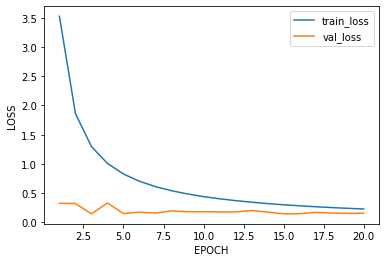

In [ ]:
# loss 변화 시각화
val_loss = {'train_loss' : avg_tr_loss_li,
            'val_loss' : avg_val_loss_li,
            'epoch' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
loss_df = pd.DataFrame(data=val_loss)

sns.lineplot(x='epoch', y='train_loss', data=loss_df, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=loss_df, label='val_loss')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.show();

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir {logdir_path}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

# Predict

## Load Model

In [ ]:
# Load model
path = '/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/model'
checkpoint = torch.load(os.path.join(path, 'model.ckpt.19'))

In [ ]:
# ckpt keys
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [ ]:
# Initialize model & optimizer & scheduler
initializer = Initializer(args)
model = initializer.model_initializer()
# optimizer, scheduler, _ = initializer.opt_sch_initializer(model, train_dataloader)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [ ]:
# model_state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Predict

In [ ]:
def predict(args, model, dev_dataloader, mode, global_step=None):
    
    # logger info
    if global_step != None:
        logger.info("***** Running test on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running test on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(d_dataset)))
    logger.info("  Eval Batch size = {}".format(args['eval_batch_size']))
    
    # loss, steps, preds, labels
    loss = 0.0
    nb_test_steps = 0
    preds = None
    out_label_ids = None
    
    # eval mode
    model.eval()

    # model to device
    model.to(device)

    # Predict !
    for batch in progress_bar(dev_dataloader):
        batch = tuple(item.to(device) for item in batch)

        # no_grad
        with torch.no_grad():
            # inputs
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }

            # outputs
            outputs = model(**inputs)

            # loss and logits
            tmp_test_loss, logits = outputs[:2]
            loss += tmp_test_loss.mean().item()
        
        nb_test_steps += 1

        # preds and labels
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
    
    # average loss
    loss = loss / nb_test_steps
    
    # preds
    if seq_cls_output_modes[args['task']] == "classification":
        preds = np.argmax(preds, axis=1)
    elif seq_cls_output_modes[args['task']] == "regression":
        preds = np.squeeze(preds)

    """ returns info
    preds           :  predictions(float)
    out_label_ids   :  labels(float)
    loss            :  loss of prediction
    """
    return preds, out_label_ids, loss

In [ ]:
# Predict !
preds, out_label_ids, loss = predict(args, model, dev_dataloader, 'test')

03/29/2022 10:06:53 - INFO - __main__ -   ***** Running test on test dataset *****
03/29/2022 10:06:53 - INFO - __main__ -     Num examples = 519
03/29/2022 10:06:53 - INFO - __main__ -     Eval Batch size = 64


# dev_score to_csv 
> 함께 제출하는 'dev_set_score.csv' 파일로 평가하시면 됩니다.

In [ ]:
# pred 실수 라벨 
pred_real_label = [pred for pred in preds]

# pred binary 라벨 생성 (원 데이터 기준 3.000점 이상일 시 1, 미만일 시 0)
pred_bi_label = [1 if i >= 3 else 0 for i in preds]

# dev_set_score file to_csv
dev['pred_real_f_label'] = pred_real_label
dev['pred_b_label'] = pred_bi_label

dev_set_score = dev[['guid', 'real_f_label', 'b_label', 'pred_real_f_label', 'pred_b_label']].rename(columns={'real_f_label':'true_real_label',
                                                                                                              'b_label':'true_binary_label',
                                                                                                              'pred_real_f_label':'predict_real_label',
                                                                                                              'pred_b_label':'predict_binary_label'})
dev_set_score.head(5)

,guid,true_real_label,true_binary_label,predict_real_label,predict_binary_label
0,klue-sts-v1_dev_00000,4.857143,1,4.910949,1
1,klue-sts-v1_dev_00001,1.428571,0,2.225322,0
2,klue-sts-v1_dev_00002,1.285714,0,1.288716,0
3,klue-sts-v1_dev_00003,3.714286,1,3.990324,1
4,klue-sts-v1_dev_00004,2.500000,0,2.774911,0


In [ ]:
fname = 'dev_set_score.csv'
dev_set_score.to_csv(f'/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/기업과제/3.STS/data/{fname}')